## Importar lo importante

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime as dt
import pickle
import numpy as np
import borrador
from __future__ import division
from auxiliar_functions import *
from aux_functions_comparisson import *
import tfe
from geopy.distance import vincenty
from itertools import chain, combinations
import random
import scipy as sp

## Obtener datos

In [2]:
with open('data/shared_rois.pickle') as f:
    shared_rois = pickle.load(f)

In [3]:
with open('data/Distancia_Euclideana/features.pickle') as f:
    abril_vectors = pickle.load(f)
    septiembre_vectors = pickle.load(f)

In [4]:
with open('data/rois_meters_data.pickle') as f:
    abril_the_rois = pickle.load(f)
    septiembre_the_rois = pickle.load(f)

In [70]:
limit = np.min((len(abril_vectors),len(septiembre_vectors)))
limit

5169

In [63]:
shared_1_rois_2_month = 0
shared_2_rois_2_month = 0
for i in range(limit):
    if shared_rois[i,i] > 0:
        shared_1_rois_2_month += 1
    if shared_rois[i,i] > 1:
        shared_2_rois_2_month += 1
print "% de tarjetas que comparten un roi en ambos meses:",str(round(shared_1_rois_2_month*100/limit,2)) + "%"
print "% de tarjetas que comparten dos roi en ambos meses:", str(round(shared_2_rois_2_month*100/limit,2)) + "%"

% de tarjetas que comparten un roi en ambos meses: 93.38%
% de tarjetas que comparten dos roi en ambos meses: 54.85%


### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [64]:
n_of_neighbours = []
for i in range(limit):
    n_of_neighbours.append(len(get_neighbours_index(abril_the_rois,shared_rois,i,2)))

(array([ 1051.,  1642.,   808.,   431.,   263.,   191.,   116.,    91.,
          117.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

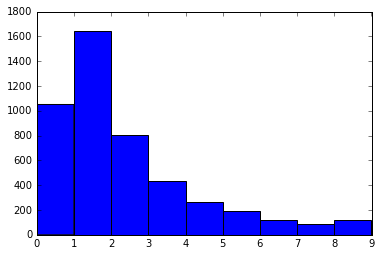

In [65]:
plt.hist(n_of_neighbours,range(10))

### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [66]:
n10_of_neighbours = filter(lambda x: x>9,n_of_neighbours)

(array([ 269.,  109.,   36.,    8.,    8.,    8.,    5.,    4.,    1.,
           0.,    0.,    1.,    2.,    1.,    0.,    0.,    0.,    0.,
           1.,    0.,    2.,    0.,    0.,    1.,    1.,    0.,    1.,
           0.,    0.,    1.]),
 array([  10.        ,   19.06666667,   28.13333333,   37.2       ,
          46.26666667,   55.33333333,   64.4       ,   73.46666667,
          82.53333333,   91.6       ,  100.66666667,  109.73333333,
         118.8       ,  127.86666667,  136.93333333,  146.        ,
         155.06666667,  164.13333333,  173.2       ,  182.26666667,
         191.33333333,  200.4       ,  209.46666667,  218.53333333,
         227.6       ,  236.66666667,  245.73333333,  254.8       ,
         263.86666667,  272.93333333,  282.        ]),
 <a list of 30 Patch objects>)

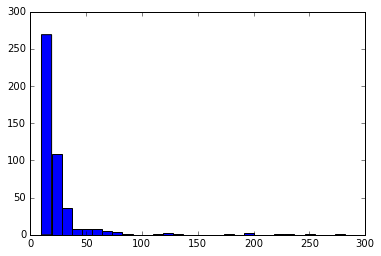

In [67]:
plt.hist(n10_of_neighbours,30)

## Feature Exploration

In [7]:
N_FEATURES = 19

In [8]:
features_names = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

In [9]:
features_dict = {"msal":0,"mlal":1,"kmDistance":2,"kmMaxDist":3,"kmMinDist":4,"rg":5,"unc_entropy":6,
                  "random_entropy":7,"p100_diff_last_origin":8,"p100_diff_first_origin":9,"card_type":10,
                  "start_time":11,"end_time":12,"traveled_days":13,"traveled_days_bs":14,"frequence_regularity":15,
                  "p100_exclusive_bus_days":16,"p100_exclusive_metro_days":17,"P100_bus_trips":18}

## Seleccionar Features para la comparación

In [10]:
selected_features = ['msal',
  'kmMaxDist',
  'rg',
  'unc_entropy',
  'card_type',
  'start_time',
  'end_time',
  'traveled_days',
  'P100_bus_trips']


In [11]:
abril_selected_features = filter_features(abril_vectors,selected_features,features_dict)
septiembre_selected_features = filter_features(septiembre_vectors,selected_features,features_dict)

### Seleccionar con distancia euclidiana y similitud braycurtis entre los vecinos con las features ya normalizadas con min max

In [12]:
abril_norm_vectors = np.ones((limit, N_FEATURES))
septiembre_norm_vectors = np.ones((limit, N_FEATURES))
for i in range(abril_selected_features.shape[1]):
    abril_norm_vectors[:,i] = normalizar_min_max(abril_selected_features[:,i])
    septiembre_norm_vectors[:,i] = normalizar_min_max(septiembre_selected_features[:,i])

In [13]:
a_matrix_euclidiana = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,abril_the_rois,\
                                           septiembre_the_rois,shared_rois,limit,2,sp.spatial.distance.euclidean)
n_identified_e,selected_distance_e,identified_indexs_e,abstenidos_e = get_n_correct(a_matrix_euclidiana,limit)
porcentaje_correcto = n_identified_e*100/limit
print "Dist Euclidiana con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"
print "Falsos positivos: "+ str(((limit-n_identified_e-len(abstenidos_e))*100/limit)) + "%"
print "Falsos negativos: "+ str(len(abstenidos_e)*100/limit) + "%"

0.72629904747
Dist Euclidiana con norma minmax general: 47.38%
Falsos positivos: 30.6442251886%
Falsos negativos: 21.9771715999%


In [138]:
a_matrix_braycurtis = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,\
                                                     abril_the_rois,septiembre_the_rois,shared_rois,limit,2,\
                                                     sp.spatial.distance.braycurtis)
n_identified_b,selected_distance_b,identified_indexs_b,abstenidos_b = get_n_correct(a_matrix_braycurtis,limit)
porcentaje_correcto = n_identified_b*100/limit
print "Dist braycurtis con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"
print "Falsos positivos: "+ str(((limit-n_identified_b-len(abstenidos_b))*100/limit)) + "%"
print "Falsos negativos: "+ str(len(abstenidos_b)*100/limit) + "%"

0.554656982422
Dist braycurtis con norma minmax general: 47.78%
Falsos positivos: 31.8823757013%
Falsos negativos: 20.3327529503%


### Ver si son los mismos seleccionados

In [139]:
corr_in_both = []
abst_in_both = []
wrong_in_both = []
corr_id_in_e = []
corr_id_in_b = []
wrong_id_in_e = []
wrong_id_in_b = []
for i in range(limit):
    if identified_indexs_b[i] == identified_indexs_e[i]:
        if identified_indexs_b[i] == -1:
            abst_in_both.append(i)
        elif identified_indexs_b[i] == i:
            corr_in_both.append(i)
        else:
            wrong_in_both.append(i)
    elif identified_indexs_b[i] != identified_indexs_e[i]:
        if  identified_indexs_b[i] == -1 and identified_indexs_e[i] == i:
            corr_id_in_e.append(i)
        elif identified_indexs_b[i] == -1:
            wrong_id_in_e.append(i)
        elif identified_indexs_e[i] == -1 and identified_indexs_b[i] == i:
            corr_id_in_b.append(i)
        else:
            wrong_id_in_b.append(i)
            

In [140]:
print "Ambos correctos: "+ str(len(corr_in_both))
print "Ambos incorrectos: "+ str(len(wrong_in_both))
print "Ambos abstenidos: "+ str(len(abst_in_both))
print "Porcentaje en ambos igual: "+ str((len(corr_in_both)+len(wrong_in_both)+len(abst_in_both))*100/limit)

Ambos correctos: 2405
Ambos incorrectos: 1379
Ambos abstenidos: 1051
Porcentaje en ambos igual: 93.538402012


In [141]:
print "Correcto con euclidiana y abstenido con braycurtis: "+ str(len(corr_id_in_e))
print "Incorrecto con euclidiana y abstenido con braycurtis: "+ str(len(wrong_id_in_e))
print "Correcto con braycurtis y abstenido con euclidiana: "+ str(len(corr_id_in_b))
print "Incorrecto con braycurtis y abstenido con euclidiana: "+ str(len(wrong_id_in_b))


Correcto con euclidiana y abstenido con braycurtis: 0
Incorrecto con euclidiana y abstenido con braycurtis: 0
Correcto con braycurtis y abstenido con euclidiana: 15
Incorrecto con braycurtis y abstenido con euclidiana: 319


### Ver en que orden queda el vector correcto con braycurtis

In [319]:
def get_position_right_answer(distance_matrix):
    positions = []
    n_neighbours = []
    n_n_correct = []
    neighbours_distances = []
    limit = len(distance_matrix)
    result = []
    possible_same_person = []
    for i in range(limit):
        neighbours = np.where(distance_matrix[i] != -1)[0]
        the_index = np.argmax(distance_matrix[i,:])
        neighbours_distances = []
        if distance_matrix[i,the_index] == -1:
            result.append((distance_matrix[i,i],-1,num_neighbours,-2))
            continue
        num_neighbours = len(neighbours)
        if distance_matrix[i,i] == -1:
            if num_neighbours == 1:
                possible_same_person.append([i,the_index])
        if num_neighbours > 0:
            for j in neighbours:
                neighbours_distances.append(distance_matrix[i,j])
            sorted_neighbours = np.sort(neighbours_distances)
                #positions.append(np.where(sorted_neighbours==distance_matrix[i,i]))
            if i != the_index:
                position = np.where(sorted_neighbours==distance_matrix[i,i])
                n_neighbours.append(num_neighbours)
                if len(position[0]) > 0:
                    result.append((distance_matrix[i,i],position[0][0],num_neighbours,distance_matrix[i,the_index]-distance_matrix[i,i]))
                else:
                    if num_neighbours == 1:
                        result.append((distance_matrix[i,i],-1,num_neighbours,-1))
                    else:
                        the_second_index = sorted_neighbours[num_neighbours-2]
                        result.append((distance_matrix[i,i],-1,num_neighbours,distance_matrix[i,the_index]-distance_matrix[i,the_second_index]))
            else:
                n_n_correct.append(num_neighbours)
                if num_neighbours == 1:
                    result.append((distance_matrix[i,i],-1,num_neighbours,-1))
                else:
                    the_second_index = sorted_neighbours[num_neighbours-2]
                    result.append((distance_matrix[i,i],0,num_neighbours,distance_matrix[i,i]-distance_matrix[i,the_second_index]))
    #return positions,n_neighbours
    return [result,n_neighbours,n_n_correct,possible_same_person]

In [285]:
qwe = [1,2,23,4,5,6]
np.sort(qwe)
len(qwe)

6

In [286]:
def get_abstenidos_and_cambio_comportamiento(distance_matrix):
    limit = len(distance_matrix)
    abstenidos = 0
    correctos = 0
    cambio_comportamiento = 0
    cambio_comportamiento_solo_un_match = 0
    sin_cambio_solo_un_match = 0
    incorrectos = 0
    for i in range(limit):
        neighbours = np.where(distance_matrix[i] != -1)[0]
        the_index = np.argmax(distance_matrix[i,:])
        if distance_matrix[i,the_index] == -1:
            abstenidos += 1
            continue
        num_neighbours = len(neighbours)
        if distance_matrix[i,i] == -1:
            cambio_comportamiento += 1
            if num_neighbours<2:
                cambio_comportamiento_solo_un_match+=1
        if distance_matrix[i,i] != -1 and num_neighbours<2 and i!= the_index:
            sin_cambio_solo_un_match +=1
        if i == the_index:
            correctos += 1
        else:
            incorrectos+=1
    return correctos*100/limit,abstenidos*100/limit,cambio_comportamiento*100/limit,\
cambio_comportamiento_solo_un_match*100/limit,sin_cambio_solo_un_match*100/limit,incorrectos*100/limit

In [287]:
a,b,c,d,e,f = get_abstenidos_and_cambio_comportamiento(a_matrix_euclidiana)
print "Porcentaje correctos: "+ str(round(a,2))
print "Porcentaje de incorrectos "+ str(round(f,2))
print "Porcentaje abstenidos: "+ str(round(b,2))
print "Porcentaje que cambian de comportamiento: "+ str(round(c+b,2))
print "Porcentaje que cambian de comportamiento y no se abstiene: "+ str(round(c,2))
print "Porcentaje que cambian de comportamiento y solo tienen un match: "+ str(round(d,2))
print "Porcentaje que no cambia de comportamiento y solo tienen un match incorrecto "+ str(round(e,2))

Porcentaje correctos: 47.38
Porcentaje de incorrectos 30.64
Porcentaje abstenidos: 21.98
Porcentaje que cambian de comportamiento: 45.71
Porcentaje que cambian de comportamiento y no se abstiene: 23.74
Porcentaje que cambian de comportamiento y solo tienen un match: 9.03
Porcentaje que no cambia de comportamiento y solo tienen un match incorrecto 0.0


In [288]:
print "Porcentaje de no tan incorrectos:", round(sum([a,b,c]),2)

Porcentaje de no tan incorrectos: 93.09


In [289]:
#TODO CHANGE pq no_penultimo esta incluyendo abstenidos
def positions(p):
    penultimo_3 = 0
    penultimo_4 = 0
    penultimo_5m = 0
    only_two = 0
    no_penultimo = 0
    tercero = 0
    for atuple in p:
        if atuple[2] == 2:
            only_two += 1
        elif atuple[2] == 3 and atuple[2]-2 == atuple[1]:
            penultimo_3 += 1
        elif atuple[2] == 4 and atuple[2]-2 == atuple[1]:
            penultimo_4 += 1
        elif atuple[2]-2 == atuple[1]:
            penultimo_5m += 1
        else: 
            if atuple[2]-3 == atuple[1]:
                tercero += 1
            else: 
                no_penultimo +=1
    print "Solo dos opciones, ",only_two*100/len(p)
    print "Penultimo de 3, ",penultimo_3*100/len(p)
    print "Penultimo de 4, ",penultimo_4*100/len(p)
    print "Penultimod de 5 o mas, ",penultimo_5m*100/len(p)
    print "Tercero de 5 o mas, ",tercero*100/len(p)
    print "Ni tercero, ",no_penultimo*100/len(p)


In [290]:
p,n_n_fail,n_n_correct,p_s_p = get_position_right_answer(a_matrix_braycurtis)

/home/cata/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cata/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [270]:
positions(p)

Solo dos opciones,  19.6943315922
Penultimo de 3,  0.735151866899
Penultimo de 4,  0.580383052815
Penultimod de 5 o mas,  41.923002515
Tercero de 5 o mas,  5.78448442639
Ni tercero,  31.2826465467


In [202]:
79-45-(27+5+9+12)/2

7.5

In [203]:
len(n_n_correct)*100/limit

47.784871348423295

### Histograma de número de vecinos cuando el algoritmo falla

(array([   0.,  467.,  289.,  193.,  127.,   94.,   55.,   54.,   44.,
          27.,   31.,   23.,   24.,   18.,   17.,   14.,   11.,    6.,
          10.,   11.,   13.,   12.,   10.,    6.,    6.,    9.,   10.,
           8.,    9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

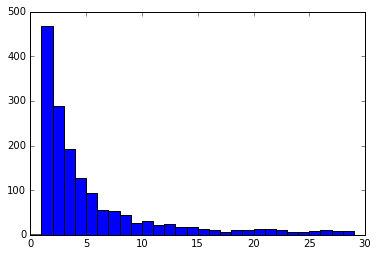

In [204]:
plt.hist(n_n_fail,range(30))

### Histograma de número de vecinos cuando el algoritmo acierta

(array([  0.00000000e+00,   1.17500000e+03,   5.19000000e+02,
          2.38000000e+02,   1.36000000e+02,   9.70000000e+01,
          6.10000000e+01,   3.70000000e+01,   2.50000000e+01,
          2.10000000e+01,   2.40000000e+01,   1.90000000e+01,
          1.30000000e+01,   7.00000000e+00,   1.30000000e+01,
          7.00000000e+00,   4.00000000e+00,   9.00000000e+00,
          7.00000000e+00,   1.00000000e+00,   6.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   7.00000000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

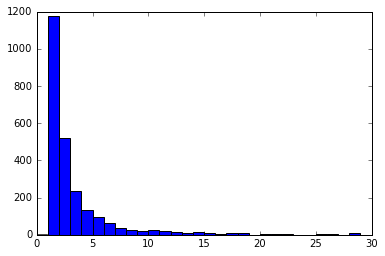

In [205]:
plt.hist(n_n_correct,range(30))

In [206]:
len(p_s_p)

467

In [207]:
num_matches = []
counter = 0
for n in p_s_p:
    n_matches = 0
    for n2 in p_s_p:
        if n2[1] == n[0] and n2[0] == n[1]:
            n_matches += 1
    num_matches.append(n_matches)
    counter += 1

(array([   0.,    0.,    0.,    0.,    0.,  467.,    0.,    0.,    0.,    0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

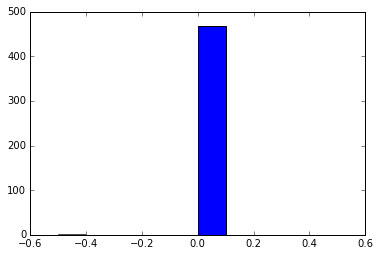

In [208]:
plt.hist(num_matches)

### Ver en que orden queda el vector correcto con euclidiana

In [301]:
p_e,n_n_fail,n_n_correct,p_s_p = get_position_right_answer(a_matrix_euclidiana)
positions(p_e)

Solo dos opciones,  19.1719868447
Penultimo de 3,  0.715805765138
Penultimo de 4,  0.522344747533
Penultimod de 5 o mas,  42.7548848907
Tercero de 5 o mas,  5.80383052815
Ni tercero,  31.0311472238


/home/cata/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cata/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [302]:
positions(p)

Solo dos opciones,  19.6943315922
Penultimo de 3,  0.735151866899
Penultimo de 4,  0.580383052815
Penultimod de 5 o mas,  41.923002515
Tercero de 5 o mas,  5.78448442639
Ni tercero,  31.2826465467


(array([  0.00000000e+00,   1.17500000e+03,   5.11000000e+02,
          2.34000000e+02,   1.37000000e+02,   1.00000000e+02,
          5.70000000e+01,   3.80000000e+01,   2.50000000e+01,
          2.30000000e+01,   2.20000000e+01,   1.80000000e+01,
          9.00000000e+00,   7.00000000e+00,   1.40000000e+01,
          8.00000000e+00,   4.00000000e+00,   8.00000000e+00,
          6.00000000e+00,   1.00000000e+00,   7.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   7.00000000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

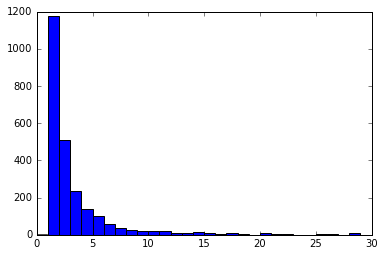

In [211]:
plt.hist(n_n_correct,range(30))

(array([   0.,  467.,  263.,  179.,  119.,   82.,   52.,   49.,   43.,
          24.,   33.,   23.,   28.,   17.,   15.,   13.,   11.,    7.,
          10.,   11.,   12.,   12.,   11.,    6.,    6.,    9.,   10.,
           7.,    9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

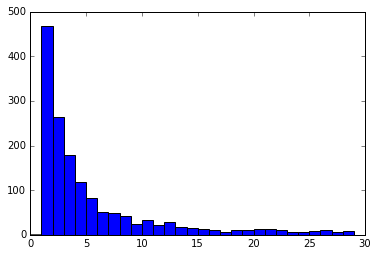

In [212]:
plt.hist(n_n_fail,range(30))

In [213]:
(70+60)*100/(1260+480)

7.471264367816092

In [214]:
df_a_vectors = pd.DataFrame(abril_vectors)

In [215]:
def get_array_identified_ids(identified_ids):
    result = []
    for i in range(len(identified_ids)):
        if i == identified_ids[i]:
            result.append(1)
        else:
            result.append(0)
    return result

# Datos para visualizar

#### Saving a sample of features with the class identified or not

In [101]:
df_a_vectors['identified'] = get_array_identified_ids(identified_indexs_e)

In [102]:
df_a_vectors.columns = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips","identified"]

All the data

In [103]:
file_path = 'abril_vectors_norm_identified'+ '.csv'
df_a_vectors.to_csv(path_or_buf=file_path)

1000 raws

In [104]:
file_path = 'abril_vectors_norm_identified_1000'+ '.csv'
df_a_vectors.sample(1000).to_csv(path_or_buf=file_path)

500 rows

In [105]:
file_path = 'abril_vectors_norm_identified_500'+ '.csv'
df_a_vectors.sample(500).to_csv(path_or_buf=file_path)

In [106]:
df0_abril_vectors = pd.read_csv('data/Distancia_Euclideana/abril_features.csv')

In [107]:
df0_abril_vectors['identified'] = get_array_identified_ids(identified_indexs_e)

In [108]:
df0_abril_vectors.head()

,# msal,mlal,kmDistance,kmMaxDist,kmMinDist,rg,unc_entropy,random_entropy,p100_diff_last_origin,p100_diff_first_origin,card_type,start_time,end_time,traveled_days,traveled_days_bs,frequence_regularity,p100_exclusive_bus_days,p100_exclusive_metro_days,P100_bus_trips,identified
0,469.714286,744.714286,195.808618,16.883693,5.586141,5450.200715,2.554585,2.321928,57.142857,42.857143,0,33061,67229,7,5,4,100.0,0,100.000000,1
1,530.200000,822.200000,115.374820,14.292865,1.393997,5287.442595,1.991076,1.584963,40.000000,40.000000,0,32320,64806,5,4,5,100.0,0,100.000000,0
2,251.375000,689.875000,105.812368,15.543822,0.474051,4689.059189,2.920597,3.321928,87.500000,50.000000,0,35691,63735,8,7,4,12.5,25,36.842105,1
3,426.600000,891.600000,24.405205,2.654686,2.343039,1217.127320,1.360964,1.584963,40.000000,20.000000,0,30747,56383,5,4,5,100.0,0,100.000000,1
4,689.400000,775.000000,95.360226,10.425179,9.932433,5021.142449,1.485475,1.584963,20.000000,40.000000,0,20398,66933,5,4,5,100.0,0,100.000000,1


In [109]:
df0_abril_vectors.columns = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips","identified"]

In [110]:
df0_abril_vectors.sample().head(10)

,msal,mlal,kmDistance,kmMaxDist,kmMinDist,rg,unc_entropy,random_entropy,p100_diff_last_origin,p100_diff_first_origin,card_type,start_time,end_time,traveled_days,traveled_days_bs,frequence_regularity,p100_exclusive_bus_days,p100_exclusive_metro_days,P100_bus_trips,identified
1174,499.8,869,67.01223,9.80771,2.564191,2732.863499,3.5,2.807355,100,60,0,46830,62380,5,3,2,100,0,100,0


In [111]:
file_path = 'abril_vectors_identified'+ '.csv'
df0_abril_vectors.to_csv(path_or_buf=file_path)

In [112]:
file_path = 'abril_vectors_identified_1000'+ '.csv'
df0_abril_vectors.sample(1000).to_csv(path_or_buf=file_path)

In [113]:
file_path = 'abril_vectors_identified_500'+ '.csv'
df0_abril_vectors.sample(500).to_csv(path_or_buf=file_path)

In [163]:
a,b,c,d,e,f = get_abstenidos_and_cambio_comportamiento(a_matrix_euclidiana)
print "Porcentaje correctos: "+ str(round(a,2))
print "Porcentaje de incorrectos "+ str(round(f,2))
print "Porcentaje abstenidos: "+ str(round(b,2))
print "Porcentaje que cambian de comportamiento: "+ str(round(c+b,2))
print "Porcentaje que cambian de comportamiento y no se abstiene: "+ str(round(c,2))
print "Porcentaje que cambian de comportamiento y solo tienen un match: "+ str(round(d,2))
print "Porcentaje que no cambia de comportamiento y solo tienen un match incorrecto "+ str(round(e,2))

Porcentaje correctos: 47.38
Porcentaje de incorrectos 30.64
Porcentaje abstenidos: 21.98
Porcentaje que cambian de comportamiento: 45.71
Porcentaje que cambian de comportamiento y no se abstiene: 23.74
Porcentaje que cambian de comportamiento y solo tienen un match: 9.03
Porcentaje que no cambia de comportamiento y solo tienen un match incorrecto 0.0


## Obtener datos de quienes son los que se roban la pelicula

In [14]:
path_csv_sequences = 'data/data_to_visualize'
# Función que filtra un data_frame según id
# y el resultado lo entrega en un archivo csv
def queryToCSV(matrix,user_id, str_diff = '', folder=''):
    query = 'id ==' + str(user_id)
    df_query = matrix.query(query)
    if folder != '':
        file_path = path_csv_sequences + '/'+folder+'/' + str(user_id) + '_' + str_diff + '.csv'
    else:
        file_path = path_csv_sequences + str(user_id) + '_' + str_diff + '.csv'
    df_query.to_csv(path_or_buf=file_path)

In [15]:
with open('data/index_id_users.pickle','r') as f:
    users_ids = pickle.load(f)

In [16]:
with open('data/datos_abril_sep_sequence.pickle') as f:
    datos_abril = pickle.load(f)
    datos_septiembre = pickle.load(f)

In [49]:
def get_stats(distance_matrix):
    identified_indexs = []
    wrong_indexs = []
    correct_indexs = []
    selected_distances = []
    n_identified = 0
    limit = len(distance_matrix)
    w_c_a = []
    for i in range(limit):
        the_index = np.argmax(distance_matrix[i,:])
        selected_distances.append(np.max(distance_matrix[i,:]))
        if distance_matrix[i,the_index] == -1:
            w_c_a.append(3)
            continue
        identified_indexs.append(the_index)
        if(the_index!=i):
            wrong_indexs.append(the_index)
            w_c_a.append(2)
        else:
            correct_indexs.append(the_index)
            n_identified += 1
            w_c_a.append(1)
    return identified_indexs,wrong_indexs,correct_indexs,selected_distances,n_identified,w_c_a


In [273]:
identified_indexs,wrong_indexs,correct_indexs,selected_distances,n_identified,w_c_a = get_stats(a_matrix_euclidiana)

(array([ 1139.,     0.,     3.,     3.,     8.,     7.,     6.,     8.,
            8.,    20.,    17.,    32.,    38.,    41.,    67.,    60.,
           85.,   113.,   147.,   191.,   206.,   248.,   264.,   224.,
          207.,   224.,   131.,    30.,     0.,  1642.]),
 array([-1.        , -0.96666667, -0.93333333, -0.9       , -0.86666667,
        -0.83333333, -0.8       , -0.76666667, -0.73333333, -0.7       ,
        -0.66666667, -0.63333333, -0.6       , -0.56666667, -0.53333333,
        -0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
        -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
        -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,  0.        ]),
 <a list of 30 Patch objects>)

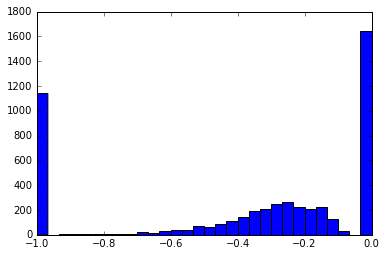

In [274]:
plt.hist(selected_distances,30)

In [303]:
a = [] 
b = []
c = []
d_a = []
d_b = []
for i in range(len(selected_distances)):
    if w_c_a[i]==1:
        a.append(selected_distances[i])
        d_a.append(p_e[i][3])
    elif w_c_a[i]==2:
        b.append(selected_distances[i])
        d_b.append(p_e[i][3])
    else:
        c.append(selected_distances[i])

([array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
           1.00000000e+00,   1.00000000e+00,   5.00000000e+00,
           7.00000000e+00,   6.00000000e+00,   1.00000000e+01,
           1.80000000e+01,   2.90000000e+01,   3.30000000e+01,
           7.00000000e+01,   8.10000000e+01,   1.11000000e+02,
           1.33000000e+02,   1.65000000e+02,   1.51000000e+02,
           1.57000000e+02,   1.71000000e+02,   1.01000000e+02,
           2.20000000e+01,   0.00000000e+00,   1.17500000e+03]),
  array([   3.,    2.,    3.,    3.,    7.,    9.,    7.,    6.,   10.,
           16.,   19.,   32.,   28.,   42.,   49.,   46.,   64.,   83.,
           85.,  108.,  105.,  111.,   91.,   64.,   57.,   39.,   25.,
            3.,    0.,  467.])],
 array([-0.98497878, -0.95214615, -0.91931353, -0.8864809 , -0.85364828,
        -0.82081565, -0.78798302, -0.7551504 ,

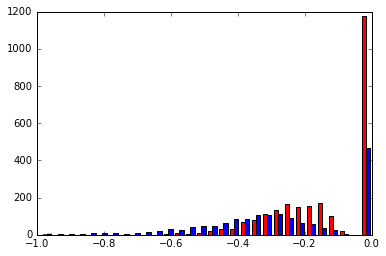

In [304]:
colors = ['red', 'blue']
plt.hist([a,b], 30, histtype='bar',color=colors)

([array([  1.17500000e+03,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
           7.00000000e+00,   1.30000000e+01,   3.10000000e+01,
           6.40000000e+01,   1.57000000e+02,   2.42000000e+02,
           3.11000000e+02,   3.23000000e+02,   1.23000000e+02]),
  array([ 467.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,   73.,  116.,   89.,
           55.,   32.,   40.,   50.,   77.,   82.,  113.,  144.,  133.,
           72.,   31.,   10.])],
 array([-1.        , -0.93557522, -0.87115043, -0.80672565, -0.74230086,
        -0.67787608, -0.61345129, -0.54902651,

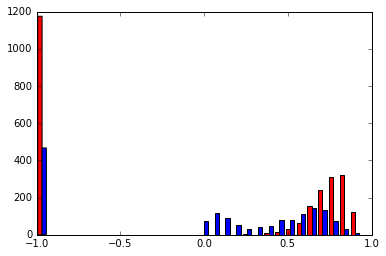

In [305]:
#TODO ENTENDER ESTO
colors = ['red', 'blue']
plt.hist([d_a,d_b], 30, histtype='bar',color=colors)

In [306]:
a_matrix_euclidiana_wo = compare_vectors_with_neighbours_normalized_without_opt(abril_norm_vectors,septiembre_norm_vectors,abril_the_rois,\
                                           septiembre_the_rois,shared_rois,limit,2,sp.spatial.distance.euclidean)

0.706387042999


In [320]:
identified_indexs_2,wrong_indexs_2,correct_indexs_2,selected_distances_2,n_identified_2,w_c_a_2 =get_stats(a_matrix_euclidiana_wo)

In [321]:
p_e_wo,n_n_fail_wo,n_n_correct_wo,p_s_p_wo = get_position_right_answer(a_matrix_euclidiana_wo)
positions(p_e_wo)

Solo dos opciones,  19.5008705746
Penultimo de 3,  0.715805765138
Penultimo de 4,  0.522344747533
Penultimod de 5 o mas,  40.6461597988
Tercero de 5 o mas,  5.80383052815
Ni tercero,  32.8109885858


/home/cata/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cata/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


([array([   0.,    0.,    0.,    0.,    0.,    1.,    1.,    0.,    0.,
            0.,    1.,    1.,    1.,    2.,    3.,    0.,    2.,    1.,
            1.,    6.,    6.,    5.,    6.,    9.,    9.,   17.,   11.,
           23.,   35.,   41.,   49.,   58.,   72.,   96.,   86.,   97.,
          117.,  137.,  160.,  177.,  163.,  165.,  149.,  171.,  192.,
          157.,  108.,   71.,   15.,    4.]),
  array([  9.,   3.,   3.,   2.,   4.,   4.,   3.,  11.,   6.,  11.,   9.,
          12.,  11.,  10.,  13.,  17.,  21.,  21.,  23.,  43.,  25.,  34.,
          39.,  32.,  47.,  44.,  35.,  42.,  45.,  51.,  64.,  55.,  64.,
          63.,  74.,  70.,  69.,  72.,  57.,  66.,  53.,  36.,  36.,  29.,
          22.,  24.,  17.,   3.,   1.,   0.])],
 array([-0.98497878, -0.96633526, -0.94769174, -0.92904821, -0.91040469,
        -0.89176117, -0.87311765, -0.85447412, -0.8358306 , -0.81718708,
        -0.79854356, -0.77990004, -0.76125651, -0.74261299, -0.72396947,
        -0.70532595, -0.686

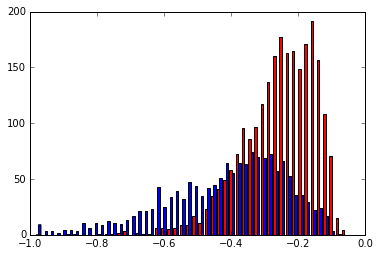

In [325]:
a_2 = [] 
b_2 = []
c_2 = []
d_a_2 = []
d_b_2 = []
for i in range(len(selected_distances_2)):
    if w_c_a_2[i]==1:
        a_2.append(selected_distances_2[i])
        d_a_2.append(p_e_wo[i][3])
    elif w_c_a_2[i]==2:
        b_2.append(selected_distances_2[i])
        d_b_2.append(p_e_wo[i][3])
    else:
        c_2.append(selected_distances_2[i])
colors = ['red', 'blue']
plt.hist([a_2,b_2], 50, histtype='bar',color=colors)

In [328]:
h=sum([165.,  149.,  171.,  192.,157.,  108.,   71.,   15.,4.])
ko=sum([36.,  36.,  29.,22.,  24.,  17.,   3.,   1.,   0.])

In [330]:
h*100.0/(h+ko)

86.0

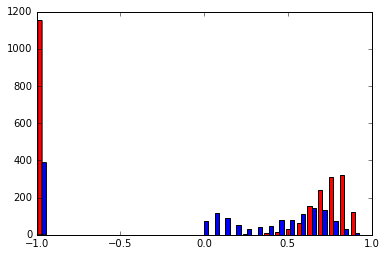

In [324]:
#TODO ENTENDER ESTO
plt.hist([d_a_2,d_b_2], 30, histtype='bar',color=colors)
plt.show()

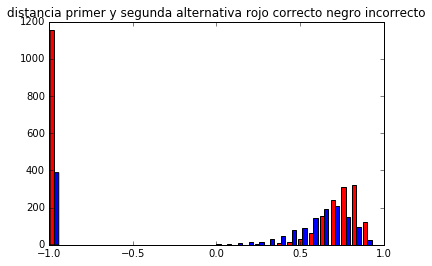

In [318]:
a_2 = [] 
b_2 = []
c_2 = []
d_a_2 = []
d_b_2 = []
for i in range(len(selected_distances_2)):
    if w_c_a_2[i]==1:
        a_2.append(selected_distances_2[i])
        d_a_2.append(p_e_wo[i][3])
    elif w_c_a_2[i]==2:
        b_2.append(selected_distances_2[i])
        d_b_2.append(p_e_wo[i][3])
    else:
        c_2.append(selected_distances_2[i])
plt.hist([d_a_2,d_b_2], 30, histtype='bar',color=colors)
#plt.title('distancia primer y segunda alternativa rojo correcto negro incorrecto')
plt.show()

## Obtener datos de los que parecen ser la misma persona (un vecino pero incorrecto)

In [19]:
def get_users_possiblu_same(distance_matrix,users_ids):
    limit = len(distance_matrix)
    possibly_same = []
    for i in range(limit):
        neighbours = np.where(distance_matrix[i] != -1)[0]
        the_index = np.argmax(distance_matrix[i,:])
        if distance_matrix[i,the_index] == -1:
            continue
        num_neighbours = len(neighbours)
        if distance_matrix[i,i] == -1:
            if num_neighbours == 1:
                possibly_same.append([i,the_index])
    return possibly_same

In [20]:
index_possibly_same = get_users_possiblu_same(a_matrix_euclidiana,users_ids)

In [21]:
for i in index_possibly_same:
    queryToCSV(datos_abril,i[0],'abril','same')
    queryToCSV(datos_septiembre,i[0],'septiembre','same')
    queryToCSV(datos_abril,i[1],'abril','same')
    queryToCSV(datos_septiembre,i[1],'septiembre','same')

In [22]:
with open('index_same.pickle','w') as f:
    pickle.dump(index_possibly_same,f)

## Obtener datos de los que cambian de comportamiento

In [148]:
def get_users_ids_change_behaviour(distance_matrix,users_ids):
    limit = len(distance_matrix)
    changed = []
    for i in range(limit):
        neighbours = np.where(distance_matrix[i] != -1)[0]
        the_index = np.argmax(distance_matrix[i,:])
        if distance_matrix[i,the_index] == -1:
            changed.append(users_ids[i])
            continue
    return changed

In [149]:
def get_users_ids_change_behaviour_one_match(distance_matrix,users_ids):
    limit = len(distance_matrix)
    changed = []
    for i in range(limit):
        neighbours = np.where(distance_matrix[i] != -1)[0]
        the_index = np.argmax(distance_matrix[i,:])
        num_neighbours = len(neighbours)
        if distance_matrix[i,i] == -1 and num_neighbours==1:
            changed.append(users_ids[i])
            continue
    return changed

In [151]:
indexs_changed_behaviour = get_users_ids_change_behaviour(a_matrix_euclidiana,users_ids)
indexs_changed_behaviour_one_match = get_users_ids_change_behaviour_one_match(a_matrix_euclidiana,users_ids)

In [152]:
len(indexs_changed_behaviour)

1136

In [153]:
len(indexs_changed_behaviour_one_match)

467

In [177]:
for i in indexs_changed_behaviour:
    queryToCSV(datos_abril,i,'abril','change')
    queryToCSV(datos_septiembre,i,'septiembre','change')
    
for j in indexs_changed_behaviour_one_match:
    queryToCSV(datos_abril,j,'abril','change_1m')
    queryToCSV(datos_septiembre,j,'septiembre','change_1m')